# EDA

### Librerías

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest

import warnings
warnings.filterwarnings("ignore")

class display(object):
    """Representador HTML de múltiples objetos"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

---

### 1. Carga de datos

In [35]:
# USAMOS DE BASE EL CONJUNTO DE DATOS YA LIMPIO
df_base = pd.read_csv('../data/processed/data_processed_1990_2023.csv', index_col='fecha')
df_base.drop('target', axis=1, inplace=True)
df_base.index = pd.to_datetime(df_base.index)
df_base.tail(7)

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
fecha,,,,,,,,,,
2023-03-02,0.5,16.9,8.7,1014.4,1017.7,30.0,1.1,5.8,11.0,0.0
2023-03-03,0.1,18.5,9.3,1013.9,1018.1,5.0,1.4,5.8,10.8,0.0
2023-03-04,6.8,17.9,12.4,1014.5,1017.6,99.0,1.9,5.0,5.2,0.0
2023-03-05,6.0,15.5,10.8,1011.0,1015.3,99.0,0.6,5.0,0.0,1.5
2023-03-06,10.3,15.9,13.1,1008.7,1013.4,21.0,1.9,8.3,0.0,3.3
2023-03-07,12.9,19.7,16.3,1009.8,1013.4,22.0,3.9,10.3,3.2,0.6
2023-03-08,14.4,20.5,17.4,1011.6,1015.1,22.0,6.1,10.3,3.2,2.5


In [36]:
df_base.describe()

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
count,12120.000000,12120.000000,12120.000000,12120.000000,12120.000000,12120.00000,12120.000000,12120.000000,12120.000000,12120.000000
mean,13.318601,25.746682,19.533146,1011.680532,1015.895167,28.83846,3.005858,9.752715,8.459170,1.417925
std,5.910120,7.860924,6.679498,5.972390,5.510833,28.18401,1.575088,3.180081,3.748671,5.200307
min,-4.000000,4.000000,2.700000,976.300000,986.800000,1.00000,0.000000,1.900000,0.000000,0.000000
25%,8.600000,18.900000,13.875000,1008.300000,1012.300000,9.00000,1.900000,7.800000,6.300000,0.000000
50%,13.400000,25.000000,19.000000,1010.900000,1015.000000,22.00000,2.800000,9.400000,9.300000,0.000000
75%,18.400000,32.400000,25.300000,1014.900000,1019.192500,27.00000,3.900000,11.400000,11.400000,0.000000
max,29.300000,46.600000,36.800000,1035.400000,1038.000000,99.00000,12.800000,31.900000,14.400000,109.300000


---

### 2. Análisis

#### 2.1 - Correlaciones

In [37]:
corr = np.abs(df_base.corr()['prec']).sort_values(ascending=True)
print(corr)

dir         0.022672
tmin        0.062720
tmed        0.164708
velmedia    0.175285
tmax        0.232724
presMax     0.256035
racha       0.308103
presMin     0.321871
sol         0.426999
prec        1.000000
Name: prec, dtype: float64


interval columns not set, guessing: ['tmin', 'tmax', 'tmed', 'presMin', 'presMax', 'dir', 'velmedia', 'racha', 'sol', 'prec']


<AxesSubplot:>

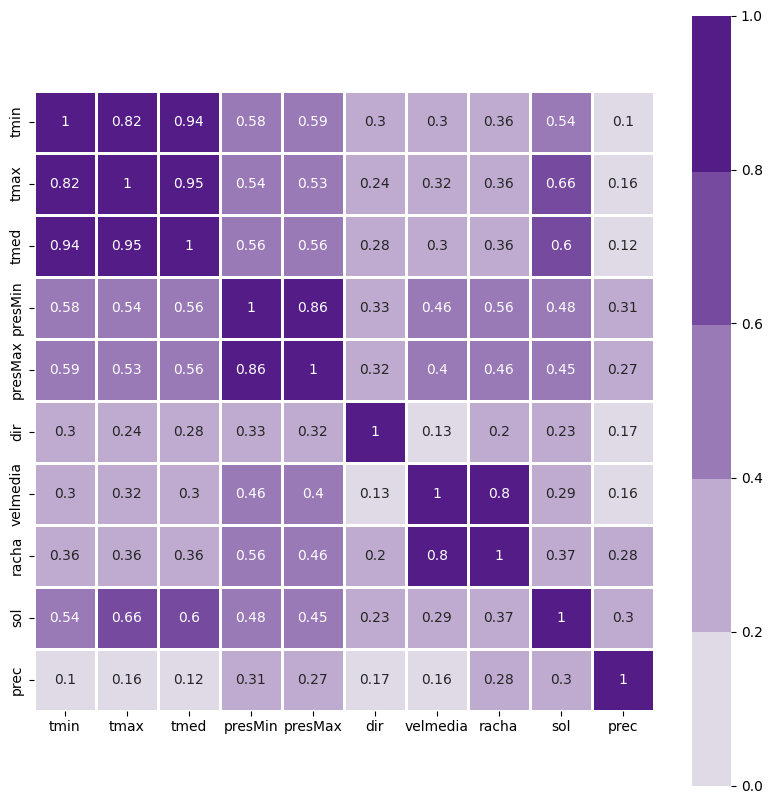

In [38]:
phik_matrix = df_base.phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(phik_matrix,
            vmin=0,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=1)


- Las mayores correlaciones se dan entre:
    - Rachas de viento y velocidad media del mismo.
    - Temperaturas mínimas, máximas y medias.
    - Presión mínima y máxima.

- Son unos resultados bastante obvios.

#### 2.2 - Feature importance

In [39]:
# USANDO RANDOM FOREST
X = df_base.iloc[:,:-1]
Y = df_base['prec']
names = df_base.columns

rf = RandomForestRegressor(n_estimators = 250)
rf.fit(X, Y)

scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.2748,sol
1,0.2185,presMin
2,0.1113,racha
3,0.0753,presMax
4,0.0737,dir
5,0.0691,tmax
6,0.0644,velmedia
7,0.0638,tmin
8,0.0491,tmed


- Los más relevantes según RF son la radiación solar y la presión atmosférica mínima.
- La presión atmosférica baja cuando se acerca un frente lluvioso, por lo que parece bastante revelador este feature.

In [40]:
# USANDO SELECT K BEST
print(X.shape)
sel = SelectKBest(k=5)
X_new = sel.fit_transform(X, Y)
print(X_new.shape)
print(sel.scores_)
names = X.columns

pd.DataFrame({'column': names, 'score': sel.scores_}
             ).sort_values('score', ascending=False)


(12120, 9)
(12120, 5)
[ 1.01595429  4.4473063   2.56325673  5.18778015  3.44741002  0.91517108
  2.75511794  5.52589263 16.44253098]


,column,score
8,sol,16.442531
7,racha,5.525893
3,presMin,5.187780
1,tmax,4.447306
4,presMax,3.447410
6,velmedia,2.755118
2,tmed,2.563257
0,tmin,1.015954
5,dir,0.915171


- SelectKBest nos ratifica lo que veíamos sobre la radiación solar, aunque también da importancia a las rachas de viento. 
- Ante cambios rápidos de presión atmosférica, se dan mayores rachas de viento, por lo que sigue teniendo sentido.

#### 3 - Analisis del target 

<AxesSubplot:title={'center':'Precipitación acumulada'}, xlabel='fecha'>

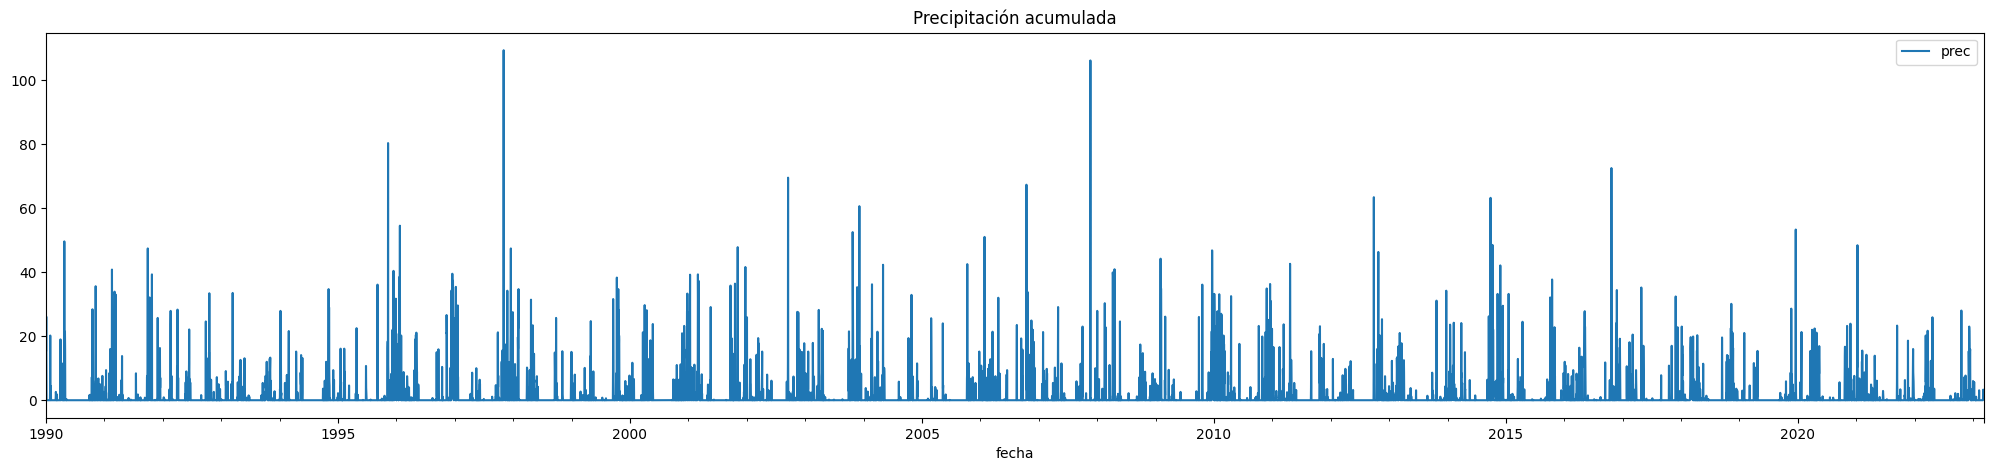

In [41]:
df_base.plot(y='prec', title='Precipitación acumulada', figsize=(25, 5))

<AxesSubplot:title={'center':'Precipitación acumulada'}, xlabel='fecha'>

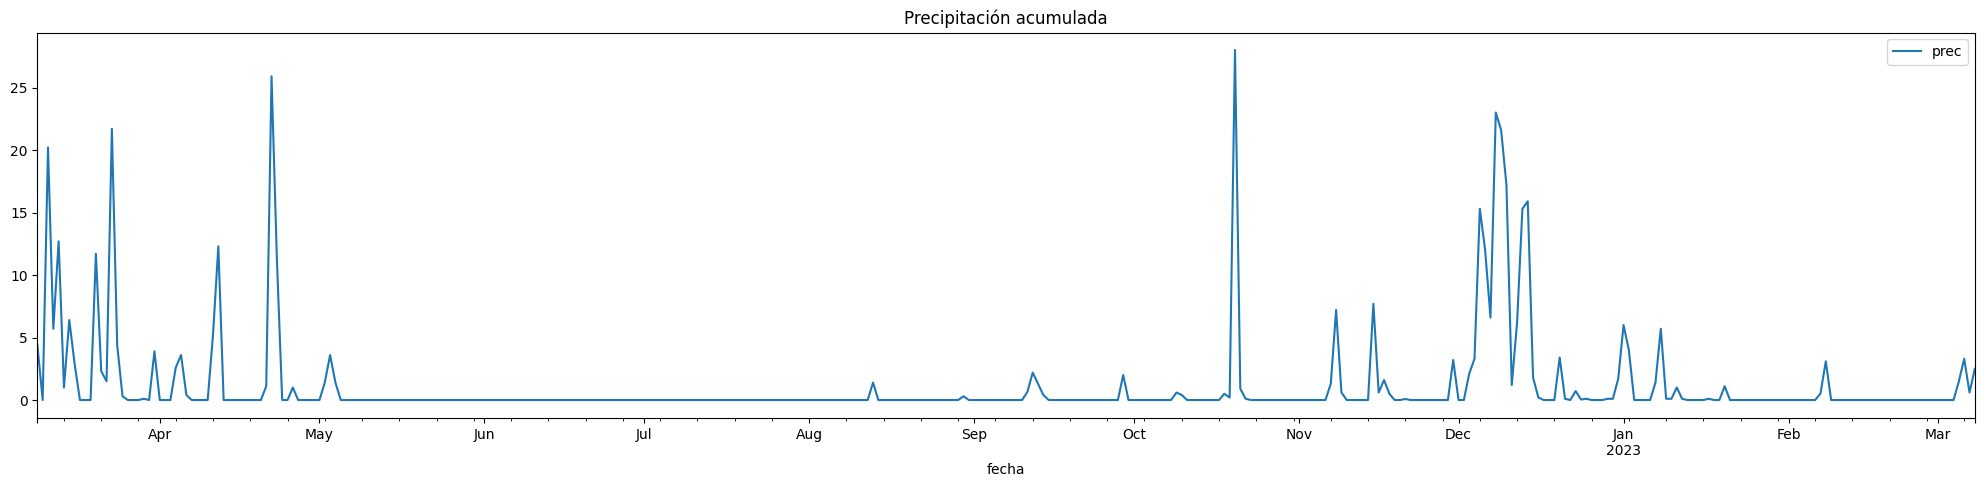

In [42]:
df_last365 = df_base.iloc[-365:]
df_last365.plot(y='prec', title='Precipitación acumulada', figsize=(25, 5))

- Outliers

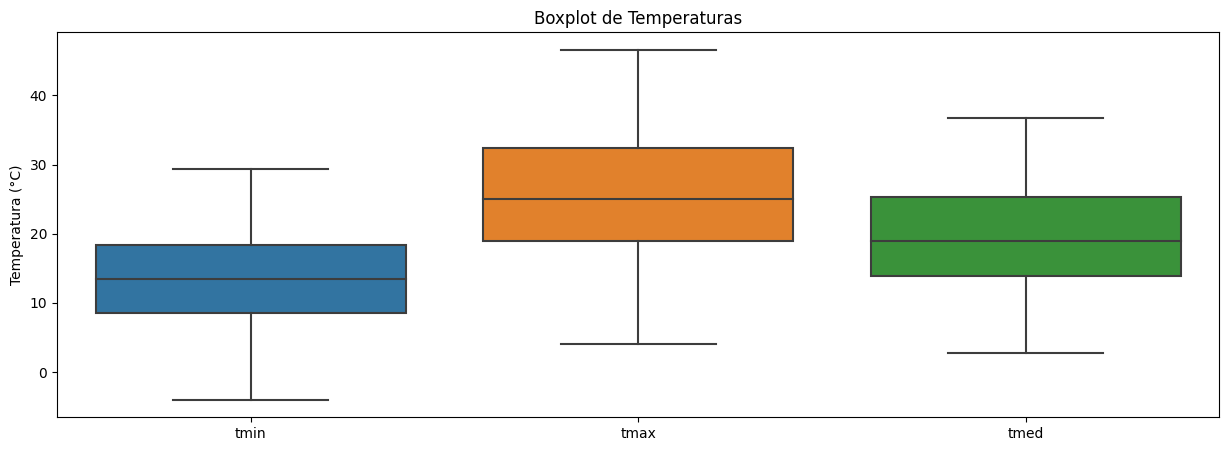

In [43]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 1, 1)
sns.boxplot(data=df_base[['tmin', 'tmax', 'tmed']], ax=ax)

ax.set_ylabel('Temperatura (°C)')
ax.set_title('Boxplot de Temperaturas')

plt.show()

<AxesSubplot:>

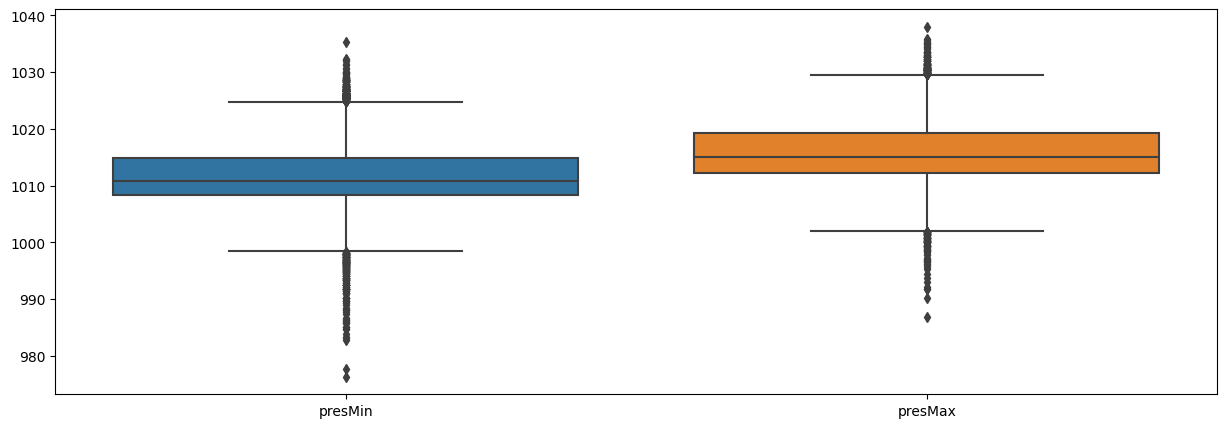

In [44]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df_base[['presMin', 'presMax']])

<AxesSubplot:>

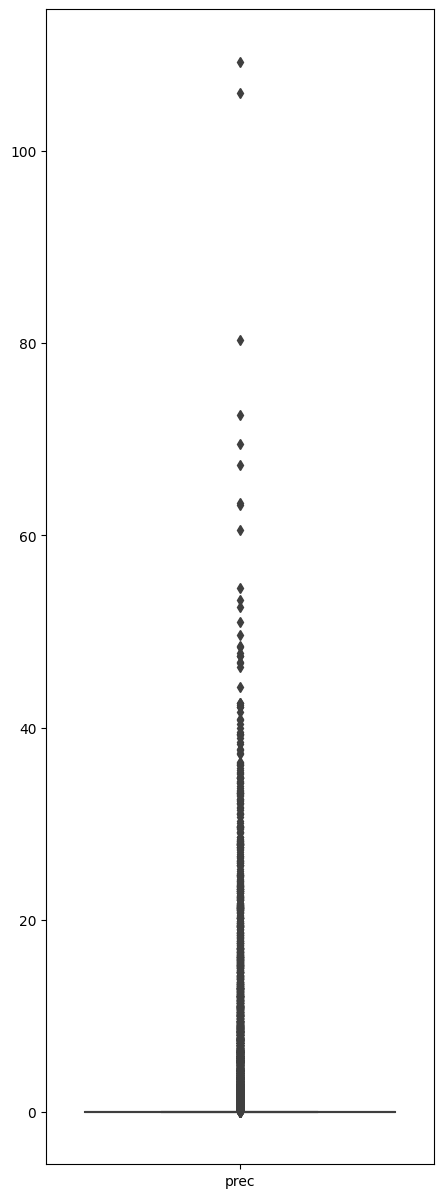

In [45]:
plt.figure(figsize=(5, 15))
sns.boxplot(data=df_base[['prec']])

- Histograma

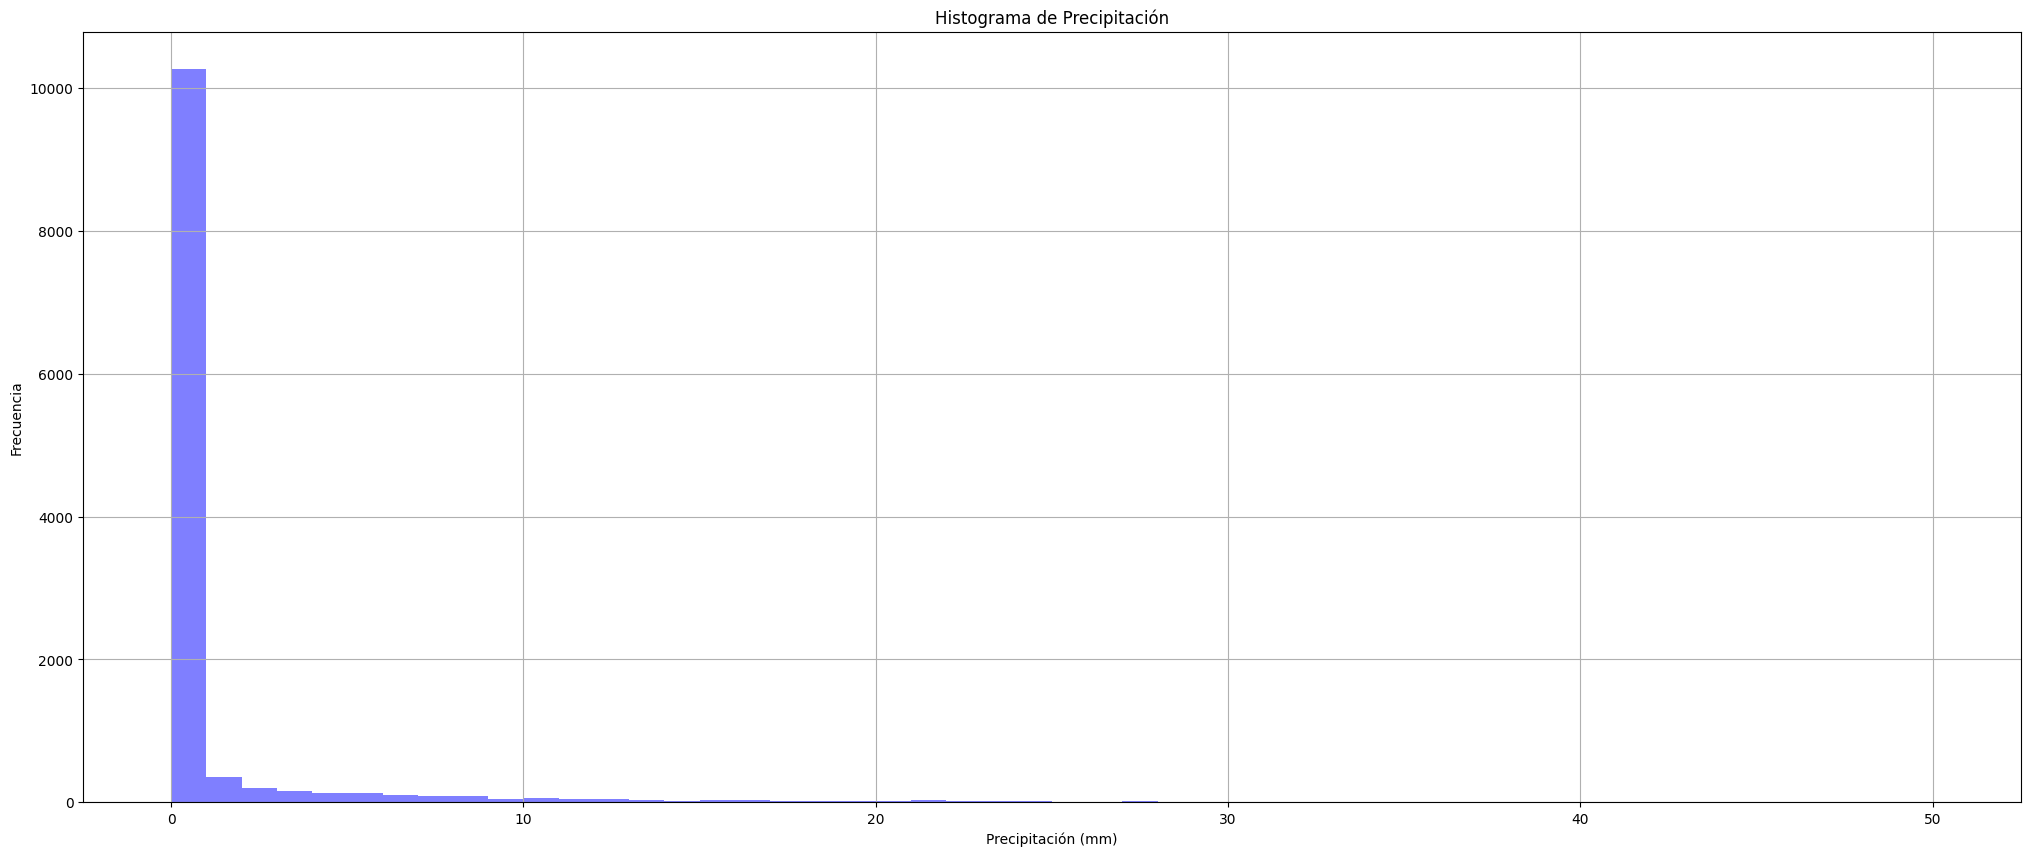

In [46]:
fig, ax = plt.subplots(figsize=(25, 10))
df_base["prec"].hist(ax=ax, bins=50, range=[0, 50], color='blue', alpha=0.5)
ax.set_title('Histograma de Precipitación')
ax.set_xlabel('Precipitación (mm)')
ax.set_ylabel('Frecuencia')
plt.show()

#### 4 - Pandas Profiling

In [48]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_base[['prec']], tsmode=True, sortby="fecha")
profile.to_file('profile_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]
